In [53]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn import metrics
from pathlib import Path
import optuna
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import eli5
from eli5.sklearn import PermutationImportance
import shap

# 解决中文乱码问题
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams["axes.unicode_minus"]=False 

In [54]:
data=pd.read_csv('./try.csv')
train_data,test_data=train_test_split(data,test_size=0.2, random_state=1318)
feature=train_data.drop(['Ea','Unnamed: 0'],axis=1)
label=train_data['Ea']
x_test=test_data.drop(['Ea','Unnamed: 0'],axis=1)
y_test=test_data['Ea']

In [55]:
kfold = KFold(n_splits = 5, random_state = 1314, shuffle = True)

In [56]:
def optuna_objective(trial):
    iterations=trial.suggest_int('iterations',100,1000,10)
    max_depth=trial.suggest_int("max_depth",2,25,1)
    lambda_l2=trial.suggest_float("lambda_l2",1,4)
    subsample=trial.suggest_float('subsample',0.3,0.9)
    colsample_bytree=trial.suggest_float('colsample_bytree',0.2,0.8)
    learning_rate=trial.suggest_float("learning_rate",0.05,0.4)
    reg=lgb.LGBMRegressor(iterations=iterations,
                             max_depth=max_depth,
                             lambda_l2=lambda_l2,
                             subsample=subsample,
                             colsample_bytree=colsample_bytree,
                             learning_rate=learning_rate,
                             verbose=-1
                             )
    loss=cross_val_score(reg,feature,label,cv=kfold,error_score='raise')
    return pow(abs(loss.mean()),0.5)

In [57]:
def optimizer_optuna(n_trials):
    algo=optuna.samplers.TPESampler(n_startup_trials=10,n_ei_candidates=24)
    study=optuna.create_study(sampler=algo,direction="maximize")
    study.optimize(optuna_objective,n_trials=n_trials,show_progress_bar=True)
    print("\n","\n","best params: ", study.best_trial.params,
          "\n","\n","best score: ", study.best_trial.values,
          "\n")
    
    return study.best_trial.params, study.best_trial.values

In [58]:
optimizer_optuna(250)

[I 2023-05-05 18:03:27,116] A new study created in memory with name: no-name-0a08c411-e508-4e03-8d6d-47814d317a2c
Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/250 [00:00<?, ?it/s]

[I 2023-05-05 18:03:27,278] Trial 0 finished with value: 0.8435488659333173 and parameters: {'iterations': 160, 'max_depth': 10, 'lambda_l2': 1.5273141399565489, 'subsample': 0.6458946174161241, 'colsample_bytree': 0.5326817785660554, 'learning_rate': 0.2591462205771665}. Best is trial 0 with value: 0.8435488659333173.
[I 2023-05-05 18:03:27,370] Trial 1 finished with value: 0.8292342938725 and parameters: {'iterations': 800, 'max_depth': 23, 'lambda_l2': 3.7258348648275095, 'subsample': 0.890184765735631, 'colsample_bytree': 0.5878453956935852, 'learning_rate': 0.08974862175498954}. Best is trial 0 with value: 0.8435488659333173.
[I 2023-05-05 18:03:27,465] Trial 2 finished with value: 0.814980594442159 and parameters: {'iterations': 780, 'max_depth': 16, 'lambda_l2': 2.4728578539450985, 'subsample': 0.5373889630524171, 'colsample_bytree': 0.32523412563292253, 'learning_rate': 0.1776358977526049}. Best is trial 0 with value: 0.8435488659333173.
[I 2023-05-05 18:03:27,558] Trial 3 fini

({'iterations': 970,
  'max_depth': 15,
  'lambda_l2': 1.5979419186566215,
  'subsample': 0.7014532478542241,
  'colsample_bytree': 0.597942320199237,
  'learning_rate': 0.2803288672086123},
 [0.8488378442294413])

In [59]:
model = lgb.LGBMRegressor(random_state=1314,iterations=1050,verbose=-1,
                          # max_depth=2,
                          colsample_bytree=0.60,
                          subsample=0.400826946817081,
                          lambda_l2=2.000885244263459946,learning_rate= 0.09).fit(X=feature , y=label)
r2_score = cross_val_score(model, feature, label, cv=kfold, scoring='r2').mean()
rmse_score = pow(abs(cross_val_score(model, feature, label, cv=kfold, scoring='neg_mean_squared_error').mean()),0.5)
print('r2:',r2_score)
print('rmse:',rmse_score)

r2: 0.7057100968244907
rmse: 0.19218237642388378


In [60]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
print('r2:',r2_score(label,model.predict(feature)))
print('MAE:',mean_absolute_error(label,model.predict(feature)))
print('测试集得分为：', r2_score(y_test,model.predict(x_test)),mean_absolute_error(y_test,model.predict(x_test)))

r2: 0.8000549053313849
MAE: 0.12231544620565737
测试集得分为： 0.749563244272721 0.14645978433520263


In [61]:
# 预测1
Y1=model.predict(test_data.drop(['Ea','Unnamed: 0'],axis=1))
Y2=test_data['Ea']
d={'Y_pred':Y1,
   'Y_True':Y2
   }
pred_show=pd.DataFrame(d)

In [62]:
# 预测2
Y_1=model.predict(feature)
Y_2=label
d_1={'Y_pred':Y_1,
   'Y_True':Y_2
   }
pred_show_1=pd.DataFrame(d_1)

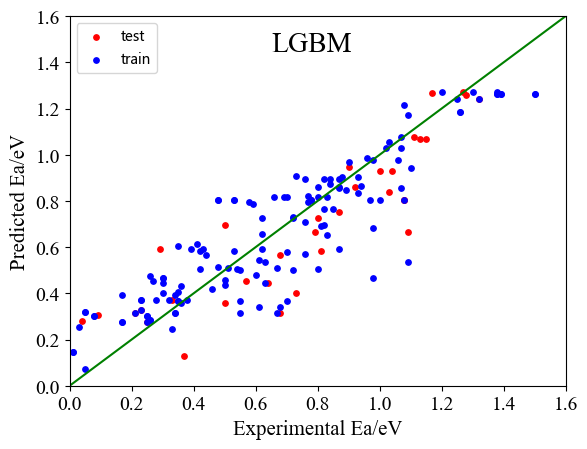

In [63]:
plt.scatter(pred_show.iloc[:,1],pred_show.iloc[:,0],color='r',s=15,label='test')
plt.scatter(pred_show_1.iloc[:,1],pred_show_1.iloc[:,0],color='b',s=15,label='train')
plt.xlim((0,1.6))
plt.xlabel('Experimental Ea/eV',fontsize=15,font=Path('..\TimesNewRoman.ttf'))
plt.xticks(fontsize=14,fontname='Times New Roman')
plt.ylim((0,1.6))
plt.ylabel('Predicted Ea/eV',fontsize=15,font=Path('..\TimesNewRoman.ttf'))
plt.yticks(fontsize=14,fontname='Times New Roman')
plt.plot([0,1.6],[0,1.6],color='g')
plt.text(0.65,1.45,'LGBM',fontsize=20,font=Path('..\TimesNewRoman.ttf'))
plt.legend()
plt.show()

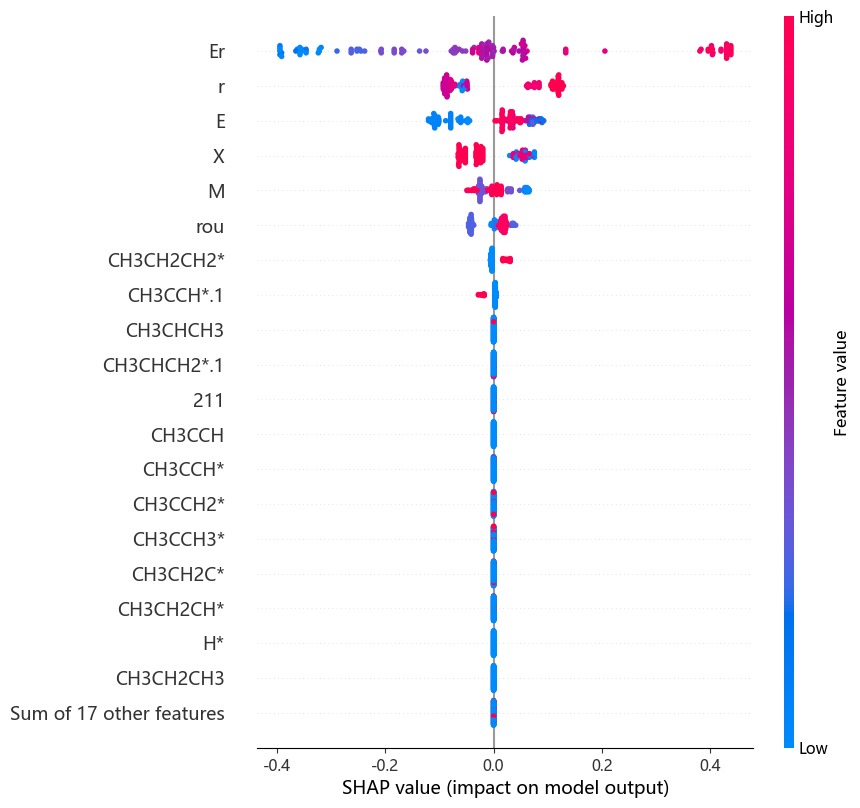

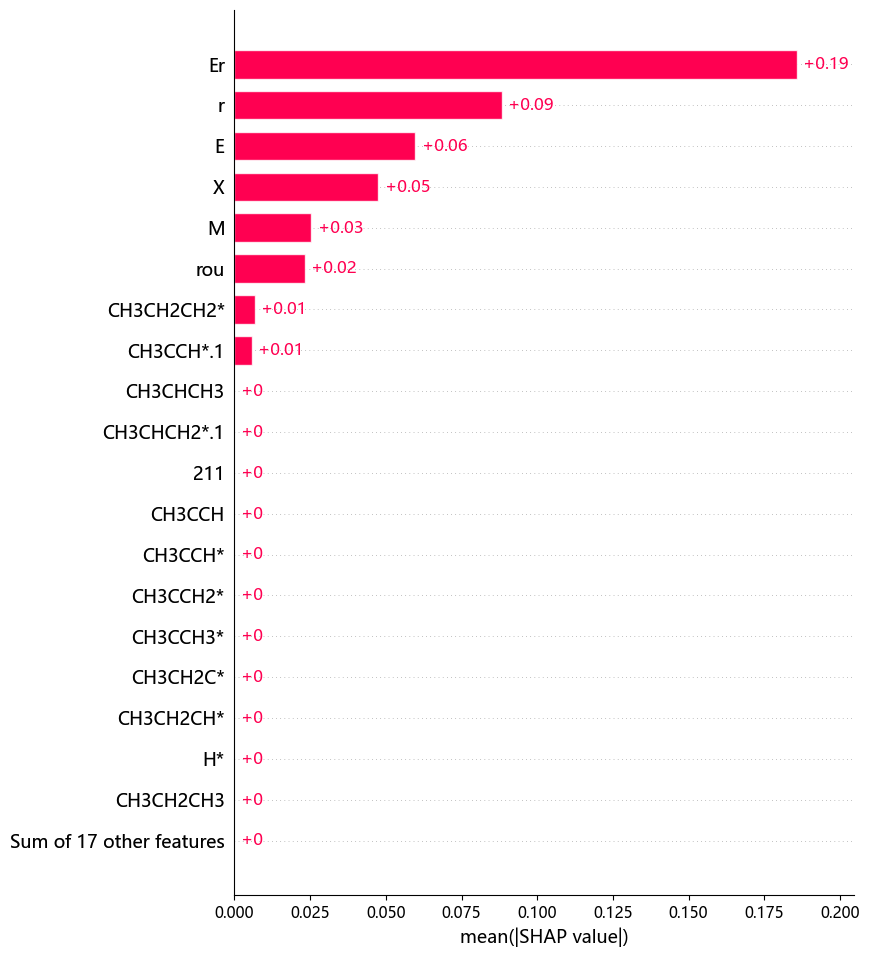

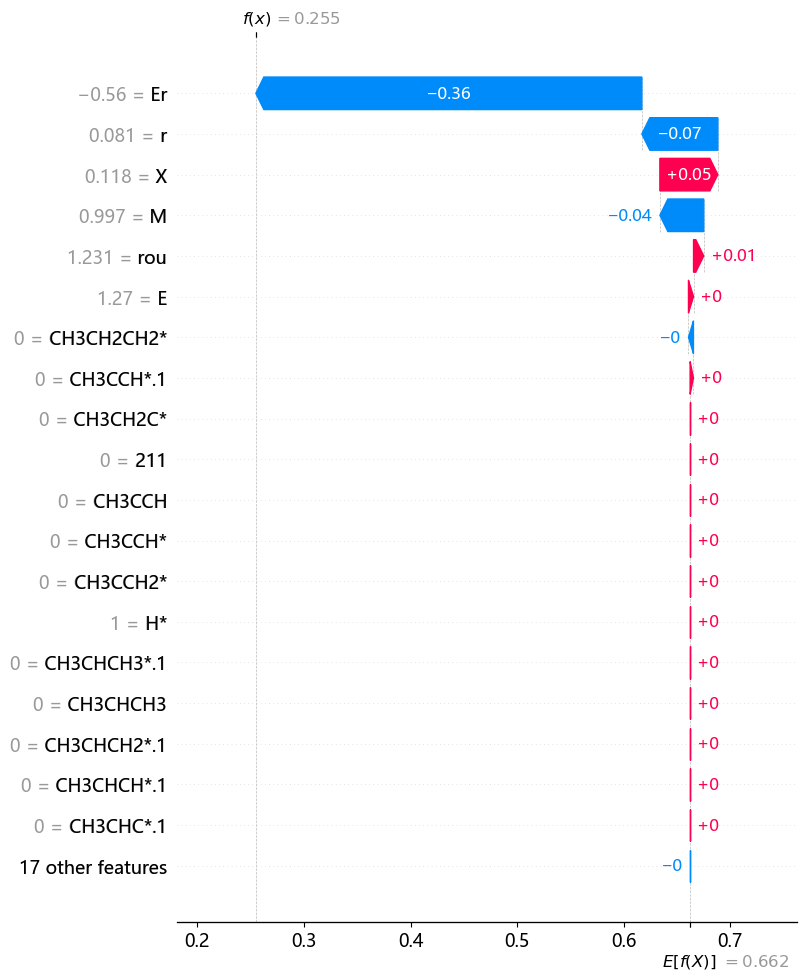

ValueError: Could not find feature named: V

In [64]:
# shap提高解释性
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer(feature)
shap.plots.beeswarm(shap_values, max_display=20)
shap.plots.bar(shap_values, max_display=20)
shap.plots.waterfall(shap_values[0], max_display=20)
shap.plots.force(shap_values[0])
shap.force_plot(explainer.expected_value, shap_values.values, feature)
shap.dependence_plot("V", shap_values.values, feature, interaction_index='温度')

In [ ]:
perm = PermutationImportance(model, random_state=1).fit(test_x, test_y)
eli5.show_weights(perm, feature_names = test_x.columns.tolist())

Weight,Feature
0.3617 ± 0.0729,V
0.3385 ± 0.0908,Con
0.2886 ± 0.0641,保护气体
0.1847 ± 0.0701,O2
0.1823 ± 0.0926,温度
0.1169 ± 0.0183,C3H8
0.1024 ± 0.0451,BN
0.0866 ± 0.0261,Al2O3
0.0642 ± 0.0277,SiO2
0.0443 ± 0.0354,GHSV
